Finding best hyperparameters...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Hyperparameter tuning time: 350.2423870563507
Optimal hyperparameters: {'lgbmclassifier__reg_lambda': np.float64(0.6000000000000001), 'lgbmclassifier__reg_alpha': np.float64(0.0), 'lgbmclassifier__max_depth': np.int64(9), 'lgbmclassifier__learning_rate': np.float64(0.35000000000000003), 'knnimputer__n_neighbors': np.int64(7)}
Cross validation score: 0.8748329109077495


c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: U

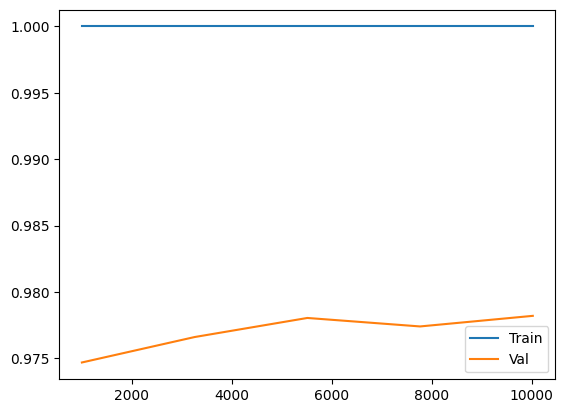

Hyperparameter tuning time: 350.2423870563507
Optimal hyperparameters: {'lgbmclassifier__reg_lambda': np.float64(0.6000000000000001), 'lgbmclassifier__reg_alpha': np.float64(0.0), 'lgbmclassifier__max_depth': np.int64(9), 'lgbmclassifier__learning_rate': np.float64(0.35000000000000003), 'knnimputer__n_neighbors': np.int64(7)}
Cross validation score: 0.8748329109077495
Final model training time: 1.318 s
Total training time: 351.5739278793335


In [ ]:
from lightgbm import LGBMClassifier
import time
import pandas as pd
from sklearn.pipeline import make_pipeline
import os
import joblib
from hyperparameter_tuning import hyper_parameter_tuning
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import seaborn as sns

def hyper_parameter_tuning(model,X_train,y_train,n_iter,learning_rate_min,learning_rate_max,learning_rate_step,max_depth_min,max_depth_max,max_depth_step,
                           reg_lambda_min,reg_lambda_max,reg_lambda_step,reg_alpha_min,reg_alpha_max,reg_alpha_step,n_neighbors_min,n_neighbors_max,n_neighbors_step):
    parameter_distributions = {
    "lgbmclassifier__max_depth" : np.arange(max_depth_min,max_depth_max,max_depth_step),
    "lgbmclassifier__learning_rate" : np.arange(learning_rate_min,learning_rate_max,learning_rate_step),
    "lgbmclassifier__reg_lambda" : np.arange(reg_lambda_min,reg_lambda_max,reg_lambda_step),
    "lgbmclassifier__reg_alpha" : np.arange(reg_alpha_min,reg_alpha_max,reg_alpha_step),
    "knnimputer__n_neighbors" : np.arange(n_neighbors_min,n_neighbors_max,n_neighbors_step)
    }
    print("Finding best hyperparameters...")
    grid = RandomizedSearchCV(estimator=model,param_distributions=parameter_distributions,n_iter=n_iter,cv=5,scoring='f1',n_jobs=-1,verbose=1)
    
    grid.fit(X_train,y_train)
    
    return grid.best_params_, grid.best_score_

# Hyperparameter tuning ranges
learning_rate_min,learning_rate_max,learning_rate_step = 0.05, 0.45, 0.1
max_depth_min, max_depth_max, max_depth_step = 5, 11, 2
n_estimators = 100
reg_lambda_min, reg_lambda_max, reg_lambda_step = 0, 0.8, 0.2  # Like L2 (Ridge) regularization on leaf nodes
reg_alpha_min, reg_alpha_max, reg_alpha_step = 0, 0.8, 0.2   # Like L1 (Lasso) regularization on leaf nodes
n_neighbors_min, n_neighbors_max, n_neighbors_step = 3, 9, 2

# Random search iterations in hyperparameter tuning
n_iter = 100

# Read data
df_train = pd.read_csv("../Data/pulsar_data_train.csv", comment="#")

X_train = df_train.drop('target_class', axis=1)
y_train = df_train['target_class'].copy()

# Split data: 60% Training, 20% Validation, 20% Test
# Validation set used only for early stopping
X_tr, X_test, y_tr, y_test = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=54
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.25, stratify=y_tr, random_state=54
)

# Save data split to csv files
X_test.to_csv("../Data/X_test.csv", index=False)
y_test.to_csv("../Data/y_test.csv", index=False)

# Impute validation data
imputer = KNNImputer(n_neighbors=5)
X_val_imp = imputer.fit_transform(X_val)

#print(X_train.head())

pos = (y_tr==1).sum()
neg = (y_tr==0).sum()
spw = neg/pos

LGBM_model = make_pipeline( KNNImputer(),
                            LGBMClassifier(n_estimators=n_estimators, random_state=54,
                                          n_jobs=-1, scale_pos_weight=spw
                                          ))

start_time_hpt = time.time()
best_params, best_score = hyper_parameter_tuning(LGBM_model,X_tr,y_tr,n_iter,learning_rate_min, learning_rate_max, learning_rate_step, 
                                                 max_depth_min, max_depth_max, max_depth_step,
                                                 reg_lambda_min, reg_lambda_max, reg_lambda_step, reg_alpha_min, reg_alpha_max, reg_alpha_step, n_neighbors_min, 
                                                 n_neighbors_max, n_neighbors_step)
end_time_hpt = time.time()
print(f"Hyperparameter tuning time: {end_time_hpt-start_time_hpt}\nOptimal hyperparameters: {best_params}\nCross validation score: {best_score}")

# Train model with optimal hyperparameters
final_LGBM_model = make_pipeline(KNNImputer(n_neighbors=best_params['knnimputer__n_neighbors']),
                                 LGBMClassifier(n_estimators=n_estimators, random_state=54,
                                    n_jobs=-1, scale_pos_weight=spw, learning_rate=best_params['lgbmclassifier__learning_rate'],
                                    max_depth=best_params['lgbmclassifier__max_depth'],
                                    reg_alpha=best_params['lgbmclassifier__reg_alpha'],
                                    reg_lambda=best_params['lgbmclassifier__reg_lambda'],verbose=-1))

start_time_train = time.time() 
# Fit model with early stopping, using validation set
final_LGBM_model.fit(X_tr, y_tr,lgbmclassifier__eval_set=[(X_val_imp,y_val)])  
end_time_train = time.time()
# Save model as .pkl file  
joblib.dump(final_LGBM_model, "model.pkl")

train_sizes, train_scores, val_scores = learning_curve(final_LGBM_model, X_train, y_train, cv=5, scoring="accuracy")
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), label='Val')
plt.legend(); plt.show()

corr = df_train.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature correlation matrix")
plt.show()

print(f"Hyperparameter tuning time: {end_time_hpt-start_time_hpt}\nOptimal hyperparameters: {best_params}\nCross validation score: {best_score}")
print(f"Final model training time: {round(end_time_train-start_time_train,3)} s")
print(f"Total training time: {end_time_train-start_time_hpt}")

c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Probability that an example positive sample is positive: 0.9999965492200024
Probability that a negative example sample is positive: 1.1869972421559397e-05
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2275
         1.0       0.88      0.83      0.85       231

    accuracy                           0.97      2506
   macro avg       0.93      0.91      0.92      2506
weighted avg       0.97      0.97      0.97      2506



c:\Users\emilw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


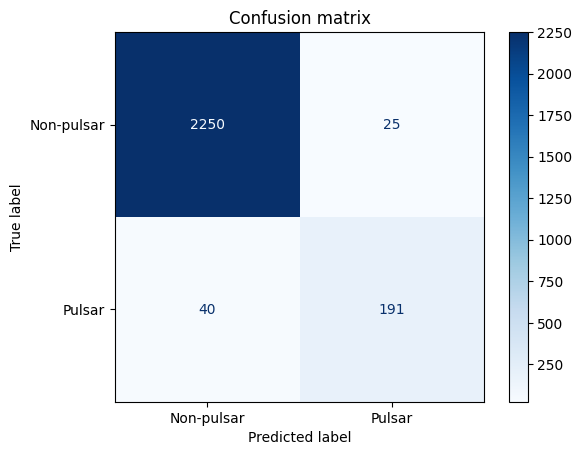

In [9]:
import joblib
import pandas as pd
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Read data
X_test = pd.read_csv("../Data/X_test.csv", comment="#", skip_blank_lines=True)
y_test = pd.read_csv("../Data/y_test.csv", comment="#", skip_blank_lines=True)

feature_names = [
    ' Mean of the integrated profile',
    ' Standard deviation of the integrated profile',
    ' Excess kurtosis of the integrated profile',
    ' Skewness of the integrated profile',
    ' Mean of the DM-SNR curve',
    ' Standard deviation of the DM-SNR curve',
    ' Excess kurtosis of the DM-SNR curve',
    ' Skewness of the DM-SNR curve'
]

false_sample_values = [121.15625,48.37297113,0.375484665,-0.013165488999999999,3.168896321,18.399366600000004,7.449874148999999,65.15929771]
true_sample_values = [41.7734375,30.20948083,3.552223686,20.28308868,12.72993311,43.22134994,3.791869842,14.13000943]
X_sample_false = pd.DataFrame([false_sample_values], columns=feature_names)
X_sample_true = pd.DataFrame([true_sample_values], columns=feature_names)

model = joblib.load("model.pkl")
print(f"Probability that an example positive sample is positive: {model.predict_proba(X_sample_true)[0][1]}\nProbability that a negative example sample is positive: {model.predict_proba(X_sample_false)[0][1]}")

y_pred = model.predict(X_test)
cla_rep = classification_report(y_test,y_pred)
#print(f"Reciever Operating Characteristic - Area Under the Curve score (roc_auc) for the model: {roc_auc}")
print(cla_rep)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-pulsar", "Pulsar"])
disp.plot(cmap="Blues")
plt.title("Confusion matrix")
plt.show()